In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from uncertainties import *
from uncertainties.umath import *  # sin(), etc.
import uncertainties.umath

from uncertainties import ufloat
from uncertainties import umath
from scipy.optimize import curve_fit
import scipy as sp
sns.set_theme(style="darkgrid")
sns.set_context("paper")

## Cosine law

In [22]:
# read in data
df=pd.read_csv("LambertschesGesetz.csv")

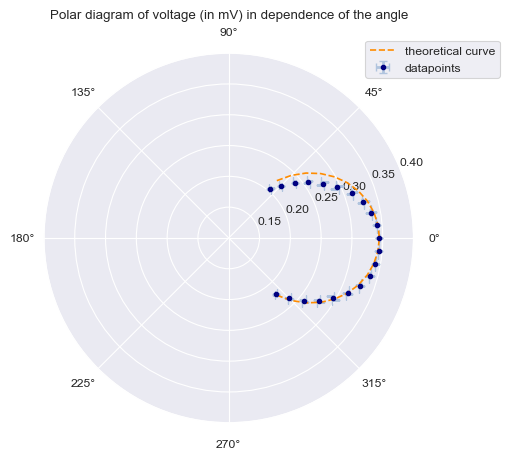

In [23]:
theta = df['Winkel'] * np.pi/180
e_theta = np.sqrt(2) * np.pi/180
r = (df['Spannung 1'] + df['Spannung 2'])/2
e_r = abs(df['Spannung 1'] - r)

plt.axes(projection='polar')
plt.title("Polar diagram of voltage (in mV) in dependence of the angle")
plt.errorbar(theta, r, xerr= e_theta, yerr=e_r, markersize=6, fmt=".",color="navy", ecolor="lightsteelblue", elinewidth=2, capsize=3, label="datapoints")
plt.plot(theta, r.max()*np.cos(theta), color = 'darkorange', ls = '--', label="theoretical curve")
plt.ylim((0.1, 0.4))
plt.legend(bbox_to_anchor=(1.25, 1.05))
plt.savefig("polarplot.png", dpi=500, bbox_inches='tight')
plt.show()

## Emitted radiation

In [130]:
# read in data, experimental parameters and constants (if needed)
df=pd.read_csv('EmittiereteStrahlung.csv')

d = ufloat(0.115, 0.0014) # distance between detector and aperture
r_aperture = ufloat(0.015, 0.0001) / 2 # radius of the aperture - error is lowered
r_detector = ufloat(0.032, 0.0001) / 2 # radius of the detector - error is lowered
epsilon = ufloat(30, 1) * 10**(-6) # nominal sensitivity

In [131]:
volt = df['Spannung'] * 10**(-3) #in V
e_volt = 0.001 * 10**(-3) #in K

volt_data = []
for i in range(len(volt)):
    volt_data.append(ufloat(volt[i],e_volt))
#volt_data

Compute from U the emitted radiation

$U = \dfrac{\epsilon E}{A_{Det}} \cdot \dfrac{A_{aperture}}{d^2} \Longrightarrow \dfrac{E}{A_{Det}} = \dfrac{U \cdot d^2}{\epsilon \cdot A_{aperture}}$

In [132]:
E_per_unit_area = (volt * d**2)/(epsilon*(r_aperture**2)*np.pi)

E_per_unit_area_nominal = np.zeros(len(E_per_unit_area))
E_per_unit_area_err = np.zeros(len(E_per_unit_area))

for i in range(len(E_per_unit_area_nominal)):
    E_per_unit_area_nominal[i] = E_per_unit_area[i].n
for i in range(len(E_per_unit_area_err)):
    E_per_unit_area_err[i] = E_per_unit_area[i].s


<ErrorbarContainer object of 3 artists>

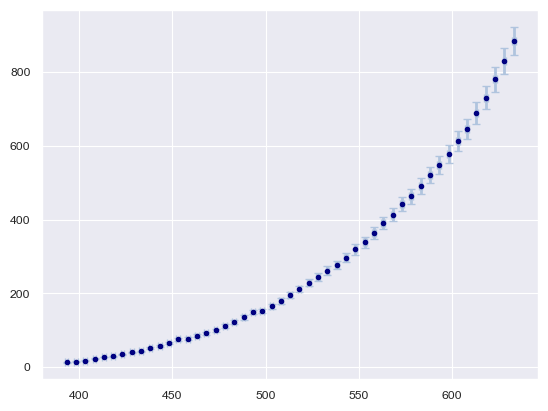

In [133]:
# plot E vs T

temp = df['Temperatur'] + 273.15 #in K
temp0 = 298.15 #room temp in K
e_temp = 1 #in K

plt.errorbar(temp, E_per_unit_area_nominal, xerr= e_temp, yerr=E_per_unit_area_err, markersize=6, fmt=".",color="navy", ecolor="lightsteelblue", elinewidth=2, capsize=3, label="Datapoints")

In [134]:
def sbl(temp, sigma):
    return sigma*(temp**4)

popt, pcov = sp.optimize.curve_fit(sbl, (temp-temp0), E_per_unit_area_nominal)#, sigma=E_per_unit_area_err)

In [135]:
print("σ = ", popt[0], "+/-", np.sqrt(pcov[0][0]))

σ =  7.294307225507196e-08 +/- 8.296458261816056e-10


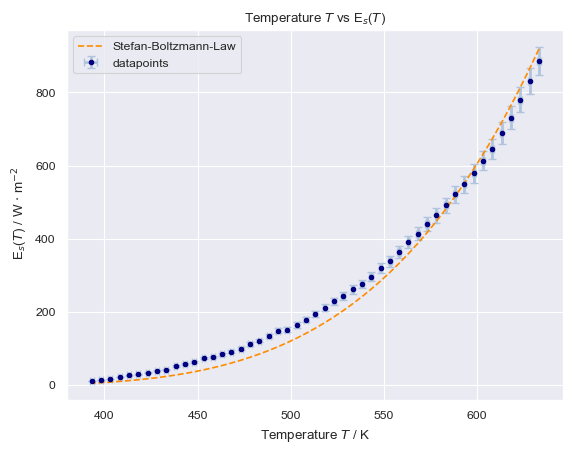

In [137]:
plt.title("Temperature $T$ vs E$_s$($T$)")
plt.errorbar(temp, E_per_unit_area_nominal, xerr= e_temp, yerr=E_per_unit_area_err, markersize=6, fmt=".",color="navy", ecolor="lightsteelblue", elinewidth=2, capsize=3, label="datapoints")
plt.plot(temp, sbl((temp-temp0), popt), color="darkorange", ls = '--', label="Stefan-Boltzmann-Law")

plt.xlabel("Temperature $T$ / K")
plt.ylabel(" E$_s$($T$) / W $\cdot$ m$^{-2}$")

plt.legend()
plt.savefig("EvsT.png", dpi=500, bbox_inches='tight')
plt.show()

In [156]:
#def log_fit(temp, sigma):
#    return np.log10(sigma) + np.log10(temp**4 - temp0**4)

In [157]:
#popt2, pcov2 = sp.optimize.curve_fit(log_fit, temp, np.log10(E_per_unit_area_nominal))

In [158]:
#popt2

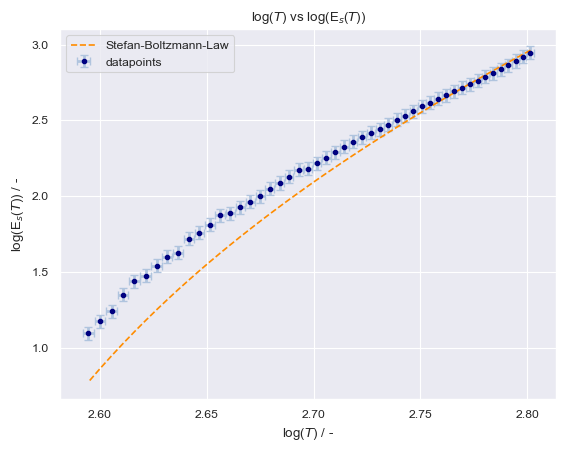

In [159]:
plt.title("log($T$) vs log(E$_s$($T$))")
plt.errorbar(np.log10(temp), np.log10(E_per_unit_area_nominal), xerr=e_temp/temp, yerr=E_per_unit_area_err/E_per_unit_area_nominal, markersize=6, fmt=".",color="navy", ecolor="lightsteelblue", elinewidth=2, capsize=3, label="datapoints")
plt.plot(np.log10(temp), np.log10(sbl((temp-temp0), popt)), color="darkorange", ls = '--', label="Stefan-Boltzmann-Law")
#plt.plot(np.log10(temp), log_fit(temp, popt2), color="lightgrey", ls = '--', label="direct fit")

plt.xlabel("log($T$) / -")
plt.ylabel("log(E$_s$($T$)) / -")

plt.legend()
plt.savefig("logEvsT.png", dpi=500, bbox_inches='tight')
plt.show()

In [179]:
dE_vs_dT_nominal = np.zeros(len(E_per_unit_area))
dE_vs_dT_err = np.zeros(len(E_per_unit_area))
for i in range(len(E_per_unit_area_nominal) - 1):
    dE_vs_dT_nominal[i] = (E_per_unit_area_nominal[i+1] - E_per_unit_area_nominal[i])/(temp[i+1] - temp[i])

dE_vs_dT_nominal = dE_vs_dT_nominal[dE_vs_dT_nominal != 0]
dE_vs_dT_nominal

array([10.97626802,  9.97842547,  9.97842547,  8.48166165,  8.48166165,
        6.48597655,  6.98489783,  5.98705528,  5.48813401,  5.98705528,
        5.48813401,  4.49029146,  5.48813401,  4.49029146,  5.48813401,
        4.98921273,  3.99137019,  4.49029146,  3.99137019,  2.99352764,
        3.49244891,  2.99352764,  3.49244891,  3.49244891,  2.99352764,
        2.99352764,  2.49460637,  0.49892127,  2.99352764,  2.49460637,
        1.99568509,  2.49460637,  1.49676382,  1.49676382,  1.49676382,
        0.49892127,  1.99568509,  1.49676382,  0.99784255,  1.99568509,
        0.49892127,  0.99784255,  0.99784255,  0.49892127,  0.99784255,
        0.99784255,  0.49892127,  0.49892127])

In [181]:
for i in range(len(E_per_unit_area_err) - 1):
    dE_vs_dT_err[i] = (E_per_unit_area_err[i+1] - E_per_unit_area_err[i])/(temp[i+1] - temp[i])

dE_vs_dT_err = dE_vs_dT_err[dE_vs_dT_err != 0]
dE_vs_dT_err

array([0.47613547, 0.43285042, 0.43285042, 0.36792286, 0.36792286,
       0.28135278, 0.3029953 , 0.25971025, 0.23806773, 0.25971025,
       0.23806773, 0.19478269, 0.23806773, 0.19478269, 0.23806773,
       0.21642521, 0.17314017, 0.19478269, 0.17314017, 0.12985513,
       0.15149765, 0.12985513, 0.15149765, 0.15149765, 0.12985513,
       0.12985513, 0.10821261, 0.02164252, 0.12985513, 0.10821261,
       0.08657008, 0.10821261, 0.06492756, 0.06492756, 0.06492756,
       0.02164252, 0.08657008, 0.06492756, 0.04328504, 0.08657008,
       0.02164252, 0.04328504, 0.04328504, 0.02164252, 0.04328504,
       0.04328504, 0.02164252, 0.02164252])

In [188]:
T_avg = np.zeros(len(dE_vs_dT_nominal))
for i in range(len(T_avg)):
    T_avg[i] = (temp[i+1] + temp[i])/2
T_avg

array([630.65, 625.65, 620.65, 615.65, 610.65, 605.65, 600.65, 595.65,
       590.65, 585.65, 580.65, 575.65, 570.65, 565.65, 560.65, 555.65,
       550.65, 545.65, 540.65, 535.65, 530.65, 525.65, 520.65, 515.65,
       510.65, 505.65, 500.65, 495.65, 490.65, 485.65, 480.65, 475.65,
       470.65, 465.65, 460.65, 455.65, 450.65, 445.65, 440.65, 435.65,
       430.65, 425.65, 420.65, 415.65, 410.65, 405.65, 400.65, 395.65])

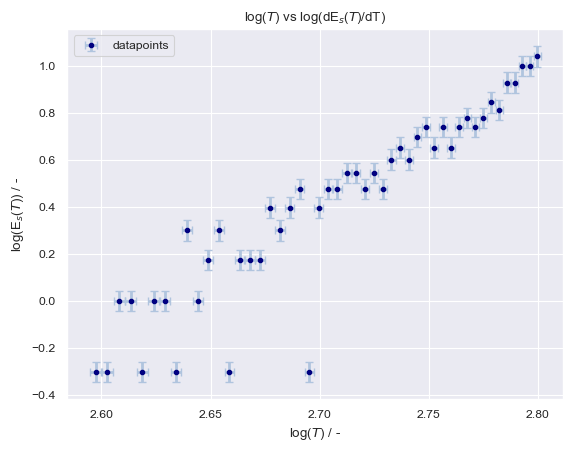

In [191]:
plt.title("log($T$) vs log(dE$_s$($T$)/dT)")
plt.errorbar(np.log10(T_avg), np.log10(dE_vs_dT_nominal), xerr=e_temp/T_avg, yerr=dE_vs_dT_err/dE_vs_dT_nominal, markersize=6, fmt=".",color="navy", ecolor="lightsteelblue", elinewidth=2, capsize=3, label="datapoints")

plt.xlabel("log($T$) / -")
plt.ylabel("log(E$_s$($T$)) / -")

plt.legend()
#plt.savefig("logdEdTvsT.png", dpi=500, bbox_inches='tight')
plt.show()